In [48]:
import torch
import torch.nn.functional as F
import torchvision
from utils.models import LeNet
import utils
from advertorch.attacks import GradientSignAttack
import matplotlib.pyplot as plt
import numpy as np

# makes default tensor a CUDA tensor so GPU can be used
device = torch.device(1 if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if device != 'cpu':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [9]:
data_preprocess = torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,))])

test_loader = torch.utils.data.DataLoader(
            torchvision.datasets.MNIST('./data', train=False, download=True,
                 transform=data_preprocess), 
            batch_size=1000, 
            shuffle=False)

In [10]:
# iterate over all models trained
training_round = 2
epsilons = [.1, .2, .3, .4, .5, .6]
alpha_wds = [0, .0000001, .000001, .00001, .0001, .001, .01]
alpha_jrs = [.0000001, .000001, .00001, .0001, .001, .01]

performance = {}

for hyp_param_to_vary in [alpha_jrs, epsilons, alpha_wds]:
    epsilon = 0
    alpha_wd = 0
    alpha_jr = 0
    
    for value in hyp_param_to_vary:
        # change hyperparameter that is being varied
        if hyp_param_to_vary == epsilons:
            descriptive_name = 'fgsm epsilon = '
            epsilon = value
        elif hyp_param_to_vary == alpha_wds:
            descriptive_name = 'weight decay coefficient = '
            alpha_wd = value
        else:
            descriptive_name = 'jacobian regularization coefficient = '
            alpha_jr = value
            
        net_name = f'models/training_round_{training_round}/ep{epsilon}_wd{alpha_wd}_jr{alpha_jr}_{training_round}'
        
        net = LeNet(activation=F.relu)   
        net.load_state_dict(torch.load(net_name))
        net.eval()
        
        net_accuracies = []
        
        for fgsm_epsilon in [0, .1, .2, .3, .4, .5, .6, .7]:
            correct = 0
            total = 0
            
            for samples, labels in test_loader:
                samples, labels = samples.to(device), labels.to(device)
                
                if fgsm_epsilon != 0:
                    FGSM = GradientSignAttack(predict=net, loss_fn=F.cross_entropy, 
                            eps=fgsm_epsilon, clip_min=-3., clip_max=3., targeted=False)
                    samples, labels = utils.generate_adversarial_samples(samples, labels, adversary=FGSM, num_per_samp=10)  

                output = net(samples)
                
                preds = output.data.max(1, keepdim=True)[1]
                correct += preds.eq(labels.data.view_as(preds)).sum().item()
                total += samples.shape[0]
        
            test_accuracy = 100. * float(correct / total)
            print(f'test accuracy for {net_name} at fgsm_epsilon = {fgsm_epsilon}:\n\t{test_accuracy}')
            
            net_accuracies.append(test_accuracy)
        
        
        performance[f'{descriptive_name}{value}'] = net_accuracies
        

test accuracy for models/training_round_2/ep0_wd0_jr1e-07_2 at fgsm_epsilon = 0:
	99.19
test accuracy for models/training_round_2/ep0_wd0_jr1e-07_2 at fgsm_epsilon = 0.1:
	95.53
test accuracy for models/training_round_2/ep0_wd0_jr1e-07_2 at fgsm_epsilon = 0.2:
	85.49
test accuracy for models/training_round_2/ep0_wd0_jr1e-07_2 at fgsm_epsilon = 0.3:
	68.46
test accuracy for models/training_round_2/ep0_wd0_jr1e-07_2 at fgsm_epsilon = 0.4:
	47.61
test accuracy for models/training_round_2/ep0_wd0_jr1e-07_2 at fgsm_epsilon = 0.5:
	28.67
test accuracy for models/training_round_2/ep0_wd0_jr1e-07_2 at fgsm_epsilon = 0.6:
	16.34
test accuracy for models/training_round_2/ep0_wd0_jr1e-07_2 at fgsm_epsilon = 0.7:
	8.84
test accuracy for models/training_round_2/ep0_wd0_jr1e-06_2 at fgsm_epsilon = 0:
	99.18
test accuracy for models/training_round_2/ep0_wd0_jr1e-06_2 at fgsm_epsilon = 0.1:
	96.15
test accuracy for models/training_round_2/ep0_wd0_jr1e-06_2 at fgsm_epsilon = 0.2:
	88.48
test accuracy f

In [12]:
names = list(performance.keys())

In [16]:
jr_names = [name for name in names if 'jacobian regularization' in name]
wd_names = [name for name in names if 'weight decay' in name]
fgsm_names = [name for name in names if 'fgsm' in name]

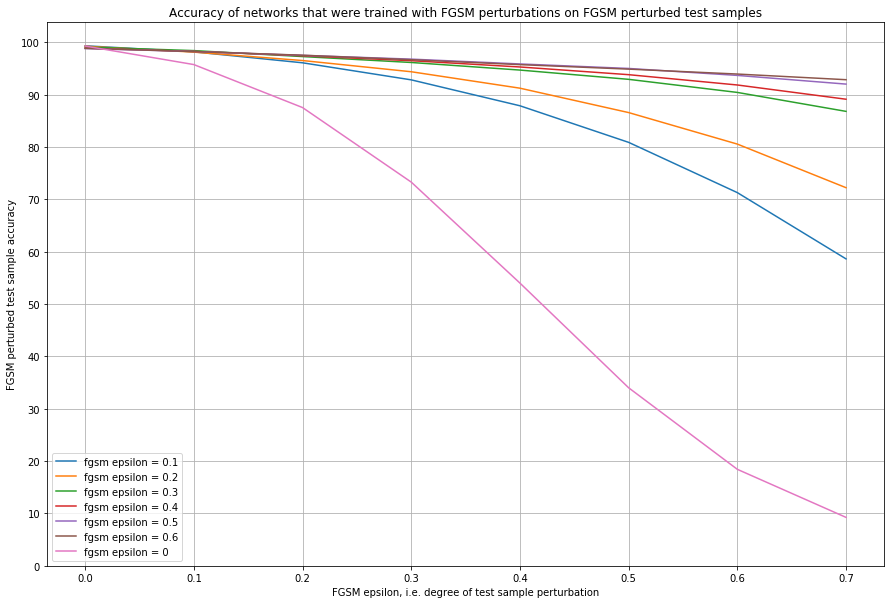

In [55]:
x = [0,.1,.2,.3,.4,.5,.6,.7]
plt.figure(figsize=(15,10))
plt.xlabel("FGSM epsilon, i.e. degree of test sample perturbation")
plt.ylabel("FGSM perturbed test sample accuracy")
plt.title("Accuracy of networks that were trained with FGSM perturbations on FGSM perturbed test samples")
for net_name in fgsm_names:
    plt.plot(x,performance[net_name],label=net_name)
plt.plot(x,performance['weight decay coefficient = 0'],label='fgsm epsilon = 0')
plt.grid()
plt.yticks(np.arange(0, 101, 10))
plt.legend()
plt.savefig('figures/fgsm_trained_nets_fgsm_accuracy.png')
plt.show()

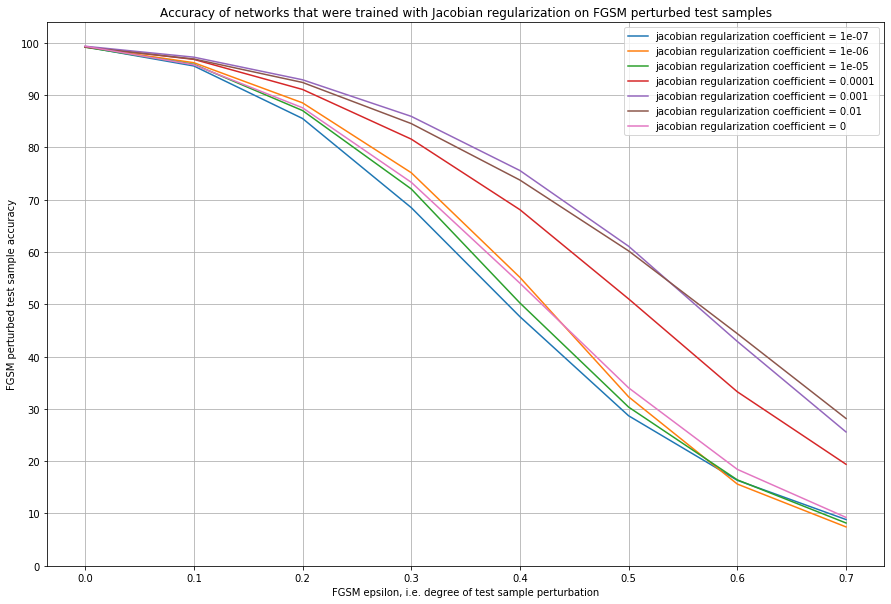

In [58]:
plt.figure(figsize=(15,10))
plt.xlabel("FGSM epsilon, i.e. degree of test sample perturbation")
plt.ylabel("FGSM perturbed test sample accuracy")
plt.title("Accuracy of networks that were trained with Jacobian regularization on FGSM perturbed test samples")
for net_name in jr_names:
    plt.plot(x,performance[net_name],label=net_name)
plt.plot(x,performance['weight decay coefficient = 0'],label='jacobian regularization coefficient = 0')
plt.grid()
plt.yticks(np.arange(0, 101, 10))
plt.legend()
plt.savefig('figures/jacobian_regularization_fgsm_accuracy.png')
plt.show()

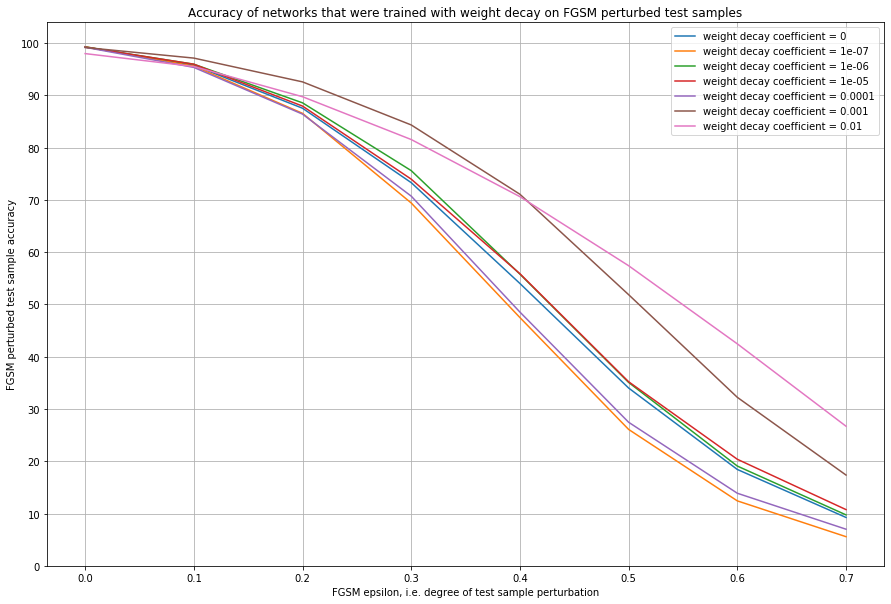

In [59]:
plt.figure(figsize=(15,10))
plt.xlabel("FGSM epsilon, i.e. degree of test sample perturbation")
plt.ylabel("FGSM perturbed test sample accuracy")
plt.title("Accuracy of networks that were trained with weight decay on FGSM perturbed test samples")
for net_name in wd_names:
    plt.plot(x,performance[net_name],label=net_name)
plt.grid()
plt.yticks(np.arange(0, 101, 10))
plt.legend()
plt.savefig('figures/weight_decay_fgsm_accuracy.png')
plt.show()